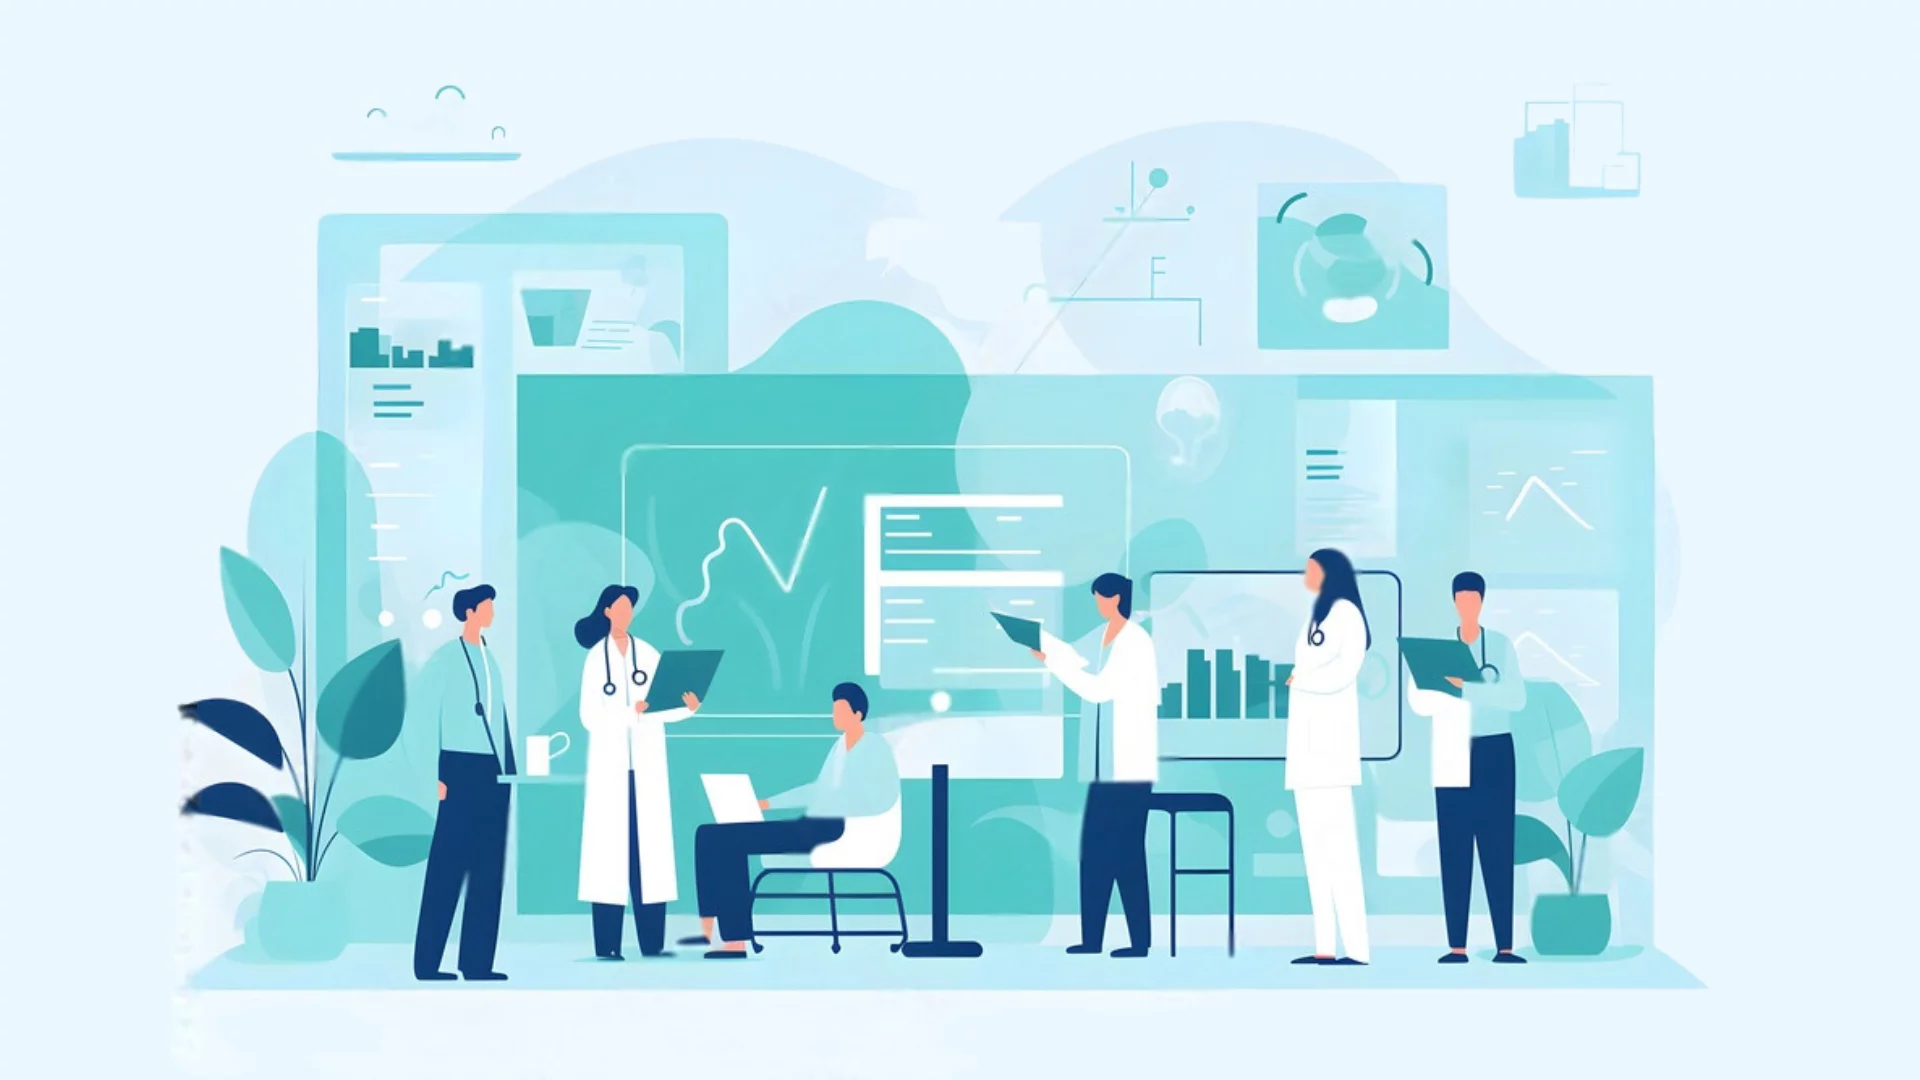

# BLUF (Bottom Line Up Front)
Analysis of two cancer cohorts reveals complex relationships between tumor characteristics, genetic mutations, smoking history, and survival outcomes. While some expected trends are observed, several unexpected findings warrant further investigation.

# Introduction
This report presents an analysis of two distinct cancer-related cohorts: a Validation Cohort and a Discovery Cohort. These datasets provide information on patient characteristics, clinical factors, and survival outcomes, offering an opportunity to explore patterns and potential prognostic indicators in cancer research.

# Objectives
1. Compare stage distributions between Validation and Discovery Cohorts, noting differences in staging systems.
2. Analyze the relationship between tumor size and survival time in the Validation Cohort.
3. Evaluate the impact of EGFR and KRAS mutations on survival outcomes.
4. Assess the influence of smoking history on survival times and explore its interaction with genetic factors.
5. Identify potential prognostic factors and areas for further research based on unexpected findings.

# Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from datetime import datetime
%matplotlib inline

In [2]:
# Load the data
validation_cohort = pd.read_csv('Clinical_Data_Validation_Cohort.csv')
discovery_cohort = pd.read_csv('Clinical Data_Discovery_Cohort.csv')

In [3]:
validation_cohort.head()

,Patient ID,Survival time (days),"Event (death: 1, alive: 0)",Tumor size (cm),Grade,Stage (TNM 8th edition),Age,Sex,Cigarette,Pack per year,Type.Adjuvant,batch,EGFR,KRAS
0,P109342,2329,1,2.6,3,IB,67,Male,Former,50.0,NaN,1,NaN,NaN
1,P124450,2532,0,3.5,3,IB,68,Female,Former,52.5,NaN,1,Negative,Negative
2,P131833,2271,0,2.0,2,IA2,80,Female,Never,0.0,NaN,1,Negative,Negative
3,P131888,2193,0,3.0,2,IA3,63,Male,Former,47.0,NaN,1,Negative,G12C
4,P131946,2387,0,4.0,2,IIIA,88,Female,Never,0.0,NaN,1,Negative,Negative


In [4]:
discovery_cohort.head()

,PatientID,Specimen date,Dead or Alive,Date of Death,Date of Last Follow Up,sex,race,Stage,Event,Time
0,1,3/17/2003,Dead,2/24/2010,2/24/2010,F,B,pT2N2MX,1,2536
1,2,6/17/2003,Dead,11/12/2004,11/12/2004,M,W,T2N2MX,1,514
2,3,9/9/2003,Dead,8/1/2009,8/1/2009,F,B,T2N1MX,1,2153
3,4,10/14/2003,Dead,12/29/2006,12/29/2006,M,W,pT2NOMX,1,1172
4,5,12/1/2003,Dead,1/31/2004,1/31/2004,F,W,T2NOMX,1,61


In [5]:
validation_cohort.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Patient ID                  95 non-null     object 
 1   Survival time (days)        95 non-null     int64  
 2   Event (death: 1, alive: 0)  95 non-null     int64  
 3   Tumor size (cm)             95 non-null     float64
 4   Grade                       95 non-null     int64  
 5   Stage (TNM 8th edition)     95 non-null     object 
 6   Age                         95 non-null     int64  
 7   Sex                         95 non-null     object 
 8   Cigarette                   95 non-null     object 
 9   Pack per year               95 non-null     float64
 10  Type.Adjuvant               22 non-null     object 
 11  batch                       95 non-null     int64  
 12  EGFR                        86 non-null     object 
 13  KRAS                        65 non-nu

- Missing values are found in `Type.Adjuvant`, `batch`, `EGFR`, and `KRAS` columns.

In [6]:
discovery_cohort.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   PatientID               30 non-null     int64 
 1   Specimen date           30 non-null     object
 2   Dead or Alive           30 non-null     object
 3   Date of Death           30 non-null     object
 4   Date of Last Follow Up  30 non-null     object
 5   sex                     30 non-null     object
 6   race                    30 non-null     object
 7   Stage                   30 non-null     object
 8   Event                   30 non-null     int64 
 9   Time                    30 non-null     int64 
dtypes: int64(3), object(7)
memory usage: 2.5+ KB


In [7]:
validation_cohort.isnull().sum()

,0
Patient ID,0
Survival time (days),0
"Event (death: 1, alive: 0)",0
Tumor size (cm),0
Grade,0
Stage (TNM 8th edition),0
Age,0
Sex,0
Cigarette,0
Pack per year,0


# Data Cleaning and Standardizing

In [8]:
# 1. Handle missing values in Validation Cohort
validation_cohort['EGFR'] = validation_cohort['EGFR'].fillna('Unknown')
validation_cohort['KRAS'] = validation_cohort['KRAS'].fillna('Unknown')
validation_cohort['Type.Adjuvant'] = validation_cohort['Type.Adjuvant'].fillna('None')

- Filling null values with Unknown and none to avoid skewing the data, since our data is already small.

In [9]:
# 2. Standardize sex/gender coding
validation_cohort['Sex'] = validation_cohort['Sex'].map({'Male': 'M', 'Female': 'F'})

In [10]:
# 3. Standardize date formats in Discovery Cohort
def standardize_date(date_str):
    if pd.isna(date_str):
        return pd.NaT
    date_str = date_str.strip()  # Remove any leading/trailing whitespace
    date_formats = ['%m/%d/%Y', '%d/%m/%Y', '%Y-%m-%d']
    for fmt in date_formats:
        try:
            return datetime.strptime(date_str, fmt)
        except ValueError:
            pass

    # If we couldn't parse the date, print an error message and return the original string
    print(f"Warning: Could not parse date '{date_str}'. Keeping original value.")
    return date_str

# Apply the improved date standardization
for col in ['Specimen date', 'Date of Death', 'Date of Last Follow Up']:
    discovery_cohort[col] = discovery_cohort[col].apply(standardize_date)

In [11]:
# 4. Rename 'Time' column in Discovery Cohort for consistency
discovery_cohort = discovery_cohort.rename(columns={'Time': 'Survival time (days)'})

In [12]:
# Verify data after cleaning
print("Validation Cohort after cleaning:")
print(validation_cohort.info())
print("\nDiscovery Cohort after cleaning:")
print(discovery_cohort.info())

Validation Cohort after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Patient ID                  95 non-null     object 
 1   Survival time (days)        95 non-null     int64  
 2   Event (death: 1, alive: 0)  95 non-null     int64  
 3   Tumor size (cm)             95 non-null     float64
 4   Grade                       95 non-null     int64  
 5   Stage (TNM 8th edition)     95 non-null     object 
 6   Age                         95 non-null     int64  
 7   Sex                         95 non-null     object 
 8   Cigarette                   95 non-null     object 
 9   Pack per year               95 non-null     float64
 10  Type.Adjuvant               95 non-null     object 
 11  batch                       95 non-null     int64  
 12  EGFR                        95 non-null     object 
 13  KRA

# Analysis using SQL

In [13]:
# Create an in-memory SQLite database
engine = create_engine('sqlite:///:memory:')

In [14]:
# Write the cleaned dataframes to SQL tables
validation_cohort.to_sql('validation_cohort', engine, index=False)
discovery_cohort.to_sql('discovery_cohort', engine, index=False)

30

In [15]:
# Function to run SQL queries
def run_query(query):
    return pd.read_sql_query(query, engine)

In [16]:
# Basic statistics for Validation Cohort
print("\nBasic statistics for Validation Cohort:")
print(run_query("""
SELECT
    COUNT(*) as total_patients,
    round(AVG("Survival time (days)"),2) as avg_survival_time,
    round(AVG("Tumor size (cm)"),2) as avg_tumor_size,
    round(AVG(Age),2) as avg_age
FROM validation_cohort
"""))


Basic statistics for Validation Cohort:
   total_patients  avg_survival_time  avg_tumor_size  avg_age
0              95            1471.52            2.85    66.59


In [26]:
print(run_query("""
    SELECT
    FLOOR("Survival time (days)" / 500) * 500 AS survival_interval,
    SUM(CASE WHEN "Event (death: 1, alive: 0)" = 0 THEN 1 ELSE 0 END) AS alive_count,
    SUM(CASE WHEN "Event (death: 1, alive: 0)" = 1 THEN 1 ELSE 0 END) AS dead_count
FROM
    validation_cohort
GROUP BY
    FLOOR("Survival time (days)" / 500)
ORDER BY
    survival_interval
    """))

   survival_interval  alive_count  dead_count
0                  0            5           6
1                500            4          14
2               1000            3          11
3               1500           24           5
4               2000           19           3
5               2500            1           0


- The above numbers show an increasing surviving days (almost to 2000 days) for patients who are alive. However, patients who are dead survived mostly between 500-1000 days.

In [18]:
# Gender distribution in both cohorts
gender_dist = run_query("""
SELECT
    'Validation' as Cohort,
    Sex,
    COUNT(*) as count
FROM validation_cohort
GROUP BY Sex
UNION ALL
SELECT
    'Discovery' as Cohort,
    sex as Sex,
    COUNT(*) as count
FROM discovery_cohort
GROUP BY sex
""")
print("\nGender distribution in both cohorts:")
print(gender_dist)


Gender distribution in both cohorts:
       Cohort Sex  count
0  Validation   F     68
1  Validation   M     27
2   Discovery   F     14
3   Discovery   M     16


- In our analysis, female counts are more than male in the validation dataset. The number of female and male are quite balance in the discovery dataset.

In [19]:
# Stage distribution in Validation Cohort
print("\nStage distribution in Validation Cohort:")
print(run_query("""
SELECT "Stage (TNM 8th edition)" as Stage, COUNT(*) as count
FROM validation_cohort
GROUP BY "Stage (TNM 8th edition)"
ORDER BY count DESC
"""))


Stage distribution in Validation Cohort:
        Stage  count
0          IB     21
1         IA3     20
2         IA2     20
3        IIIA     13
4         IIB     12
5  Recurrence      3
6        IIIB      3
7         IIA      2
8         IVA      1


- The most common stage is IB, with 21 patients, following by IA3 and IA2, each with 20 patients.
There are fewer patients in more advanced stages (IIIA, IIB, IIIB).
Only 3 patients have recurrent cancer.
There's just 1 patient with stage IVA, the most advanced stage in this cohort.

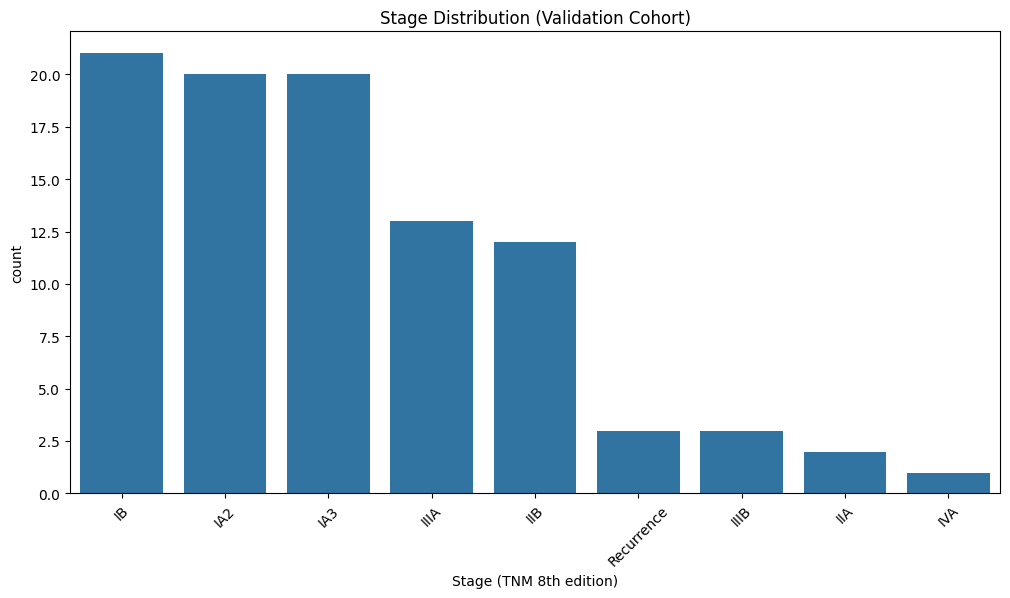

In [24]:
# stage distribution in Validation data
plt.figure(figsize=(12, 6))
sns.countplot(data=validation_cohort, x='Stage (TNM 8th edition)', order=validation_cohort['Stage (TNM 8th edition)'].value_counts().index)
plt.title('Stage Distribution (Validation Cohort)')
plt.xticks(rotation=45)
plt.show()

In [20]:
# Stage distribution in Discovery Cohort
print("\nStage distribution in Discovery Cohort:")
print(run_query("""
SELECT Stage, COUNT(*) as count
FROM discovery_cohort
GROUP BY Stage
ORDER BY count DESC
"""))


Stage distribution in Discovery Cohort:
        Stage  count
0        T2N0      7
1      PT1PN0      5
2        T1N0      3
3      PT2PN0      3
4      pT2pN0      1
5     pT2NOMX      1
6     pT2N2MX      1
7      pT1pN0      1
8      T2NOMX      1
9      T2N2MX      1
10     T2N1MX      1
11     T1NOMX      1
12     PT4PN1      1
13     PT3PN0      1
14     PT2PN1      1
15   pT3N0Mx       1


- The staging system used is different and more varied compared to the Validation Cohort.
T2N0 is the most common stage, with 7 patients, following by PT1PN0, with 5 patients.
There's a wide variety of other stages, each with only 1 or 3 patients.
The staging includes more detailed information (like MX, which typically means the presence of distant metastasis cannot be assessed).

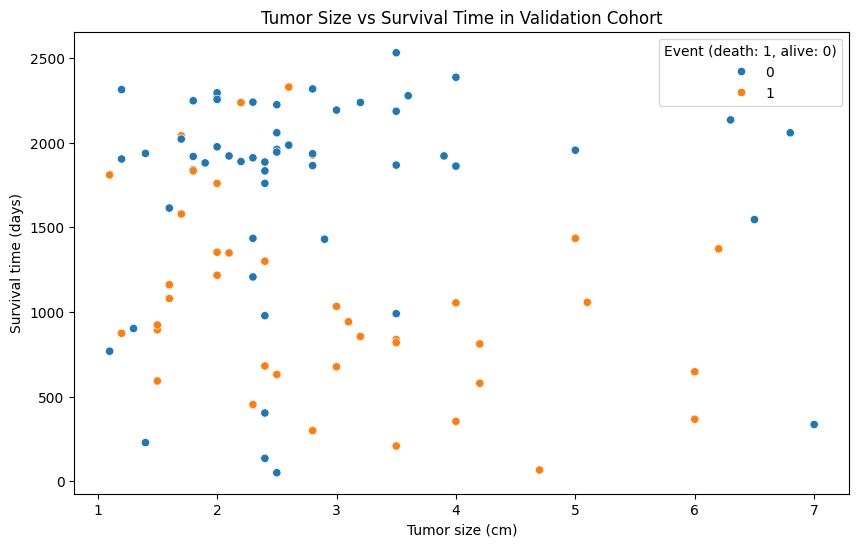

In [21]:
# Correlation between tumor size and survival time in Validation Cohort
plt.figure(figsize=(10, 6))
sns.scatterplot(data=validation_cohort, x="Tumor size (cm)", y="Survival time (days)", hue="Event (death: 1, alive: 0)")
plt.title("Tumor Size vs Survival Time in Validation Cohort")
plt.show()

- From the above graph, we can see patients who are alive mostly have smaller tumor size and a longer survival days. However, while there's a slight trend suggesting that larger tumors may be associated with shorter survival times, the relationship is not strong or straightforward, since outliers are oberseved. The graph illustrates the complex nature of cancer outcomes, where tumor size alone is not a definitive predictor of survival time.

In [22]:
# EGFR and KRAS mutation analysis in Validation Cohort
print("\nEGFR and KRAS mutation analysis in Validation Cohort:")
print(run_query("""
SELECT
    EGFR,
    KRAS,
    COUNT(*) as count,
    round(AVG("Survival time (days)"),2) as avg_survival_time
FROM validation_cohort
GROUP BY EGFR, KRAS
ORDER BY 4 DESC
"""))


EGFR and KRAS mutation analysis in Validation Cohort:
                     EGFR      KRAS  count  avg_survival_time
0   Exon 19 (24bp delete)   Unknown      1            1986.00
1                 Exon 19   Unknown      8            1985.13
2                Negative      G12R      1            1945.00
3         Exon 21 (L858R)  Negative      1            1889.00
4                Negative      G13D      1            1881.00
5                Negative      G13F      1            1860.00
6                Negative  Negative     31            1640.39
7                Negative      G12V      8            1576.38
8                Negative      G12A      3            1542.33
9                 Exon 21   Unknown      3            1509.33
10               Negative      G12F      2            1505.50
11   Exon 19 (9bp delete)   Unknown      2            1464.00
12                Unknown   Unknown      9            1241.11
13               Negative      G12C      9            1240.89
14             

- The results suggests that the type of genetic mutation (EGFR or KRAS) may influence survival time, with EGFR mutations potentially associated with longer survival. However, the presence of unknown statuses and small sample sizes for some combinations means these results should be interpreted cautiously. Further statistical analysis would be needed to determine if these differences are significant.

In [23]:
# Smoking status analysis in Validation Cohort
print("\nSmoking status analysis in Validation Cohort:")
print(run_query("""
SELECT
    Cigarette as smoking_status,
    COUNT(*) as count,
    round(AVG("Survival time (days)"),2) as avg_survival_time,
    round(AVG("Pack per year"),2) as avg_pack_years
FROM validation_cohort
GROUP BY Cigarette
"""))


Smoking status analysis in Validation Cohort:
  smoking_status  count  avg_survival_time  avg_pack_years
0        Current     11            1340.82           40.23
1         Former     62            1542.48           37.69
2          Never     22            1336.86            0.00


- Surprisingly, this data suggests that smoking history does have an impact on survival times, but the relationship is not straightforward. The surprisingly high survival time for former smokers might indicate that quitting smoking, even after a cancer diagnosis, could be beneficial. However, more detailed analysis would be needed to confirm these trends and account for other influential factors.